In [ ]:
import requests
import datetime
from datetime import timezone
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import time
#load 
tokenizer = AutoTokenizer.from_pretrained
sentiment_classes = ["positive", "negative", "neutral"]
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
						
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

class Post:
    date = None
    permalink = None
    is_video = None
    num_comments = None
    score = None
    gilded = None
    title = None
    comments = None
    body = None
    id = None

    def __init__(self):
        num_comments = 0
def create_feature_vec_for_post(post):
    post_body = post.body

    if len(post_body) > 512:
        post_body = post_body[:512]
    post_score = post.score
    
    split_body = post_body.split(' ')

    btc_counter = 0

    for word in split_body:
        if word.lower() == 'btc':
            btc_counter += 1

    tokenize_input = tokenizer.encode_plus(post_body, return_tensors="pt")
    classification_logits = model(**tokenize_input)[0]
    model_evaluation = torch.softmax(classification_logits, dim=1).tolist()

    number_words = len(split_body)

    model_eval_to_list = list(model_evaluation)

    feature_vector_as_list = [number_words, post_score, btc_counter]

    for data in model_eval_to_list[0]:
        feature_vector_as_list.append(data)

    feature_vector_to_numpy = np.array(feature_vector_as_list)
    
    return feature_vector_to_numpy

    
def create_feature_vec(input_data):
    comment_body = input_data['body']

    if len(comment_body) > 512:
        comment_body = comment_body[:512]

    words_in_comment = comment_body.split(' ')

    btc_counter = 0
    for word in words_in_comment:
        if word.lower() == 'btc':
            btc_counter += 1
    
    score = input_data['score']

    tokenize_input = tokenizer.encode_plus(comment_body, return_tensors="pt")
    classification_logits = model(**tokenize_input)[0]
    model_evaluation = torch.softmax(classification_logits, dim=1).tolist()
    number_words = len(words_in_comment)
    
    model_eval_to_list = list(model_evaluation)


    feature_vector_as_list = [number_words, score, btc_counter]

    for data in model_eval_to_list[0]:
        feature_vector_as_list.append(data)

    feature_vector_to_numpy = np.array(feature_vector_as_list)
    
    return feature_vector_to_numpy

subreddit = "bitcoin"
postList = []
start_date = datetime.date(2018, 5, 3)
end_date = datetime.date(2021, 2, 1)
delta = datetime.timedelta(days=1)
data = np.array([[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]])

while start_date <= end_date:
    next_date = start_date + delta
    #TODO: Find a solution to the potential problem that api only returns 100
    #      results per request. May be problematic for both comments&posts
    reqStr = ("https://api.pushshift.io/reddit/search/submission/?subreddit=" + 
    subreddit + "&sort=desc&sort_type=created_utc&after=" + str(start_date) + 
    "&before=" + str(next_date) +"&size=100&aggs=link_id")
    resp = requests.get(reqStr)
    if resp.status_code ==200:
        start_date = next_date
        json = resp.json()

        avg_vec = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
        count = 0

        if len(json["data"])!=0:
            for p in range(len(json["data"])):
                if count > 100:
                    break
                try:
                    postInfo = json["data"][p]
                    post = Post()
                    post.date = start_date
                    post.permalink = postInfo["permalink"]
                    post.num_comments = postInfo["num_comments"]
                    post.score = postInfo["score"]
                    post.title = postInfo["title"]
                    post.body = postInfo["selftext"]
                    post.comments = []
                    post.id = postInfo["id"]
                    #make requests for comments here,add comments to list
                    commentsRetrieved = False
                    post_feature_vec = create_feature_vec_for_post(post)
                    avg_vec += post_feature_vec
                    count += 1
                except Exception:
                    continue
                while commentsRetrieved == False:
                    commentIdReq ="https://api.pushshift.io/reddit/submission/comment_ids/" + post.id
                    resp = requests.get(commentIdReq)
                    #Make sure we try again until we recieve the response to query
                    if(resp.status_code == 200):
                        json2 = resp.json()
                        if(len(json2["data"]) != 0):
                            commentIDS = json2["data"]
                            #Loop through each comment id, making a request for
                            #each comment and storing its data
                            thisCRet = False

                            for id in commentIDS:

                                while thisCRet ==False:
                                  commentReq = "https://api.pushshift.io/reddit/comment/search?ids=" + id
                                  cResp = requests.get(commentReq)
                                  if cResp.status_code ==200:
                                      try:
                                        commentData = cResp.json()['data'][0]
                                        score = commentData['score']
                                        body = commentData['body']
                                        thisCRet = True
                                        #Create the feature vec
                                        comment_features = create_feature_vec(commentData)
                                        avg_vec += comment_features
                                        count += 1
                                        if count > 100:
                                            commentsRetrieved = True
                                            thisCRet = True
                                            break
                                      except Exception:
                                          continue
                            commentsRetrieved = True
                        else:
                          commentsRetrieved = True
                    elif(resp.status_code == 500):
                        commentsRetrieved = True
        
        avg_vec = avg_vec/count
        avg_vec = np.insert(avg_vec, 0, time.mktime(start_date.timetuple()))
        data = np.vstack((data, avg_vec))
        np.savetxt('data.csv', data, delimiter=",")

        #If  we don't get a good response code we try again

{'data': [{'author': 'Logical007', 'author_created_utc': 1405120440, 'author_flair_css_class': None, 'author_flair_text': None, 'author_fullname': 't2_hd1is', 'created_utc': 1410998339, 'domain': 'self.Bitcoin', 'full_link': 'https://www.reddit.com/r/Bitcoin/comments/2gpmuv/i_now_use_bitcoin_for_2025_of_my_monthly_expenses/', 'gilded': 0, 'id': '2gpmuv', 'is_self': True, 'media_embed': {}, 'num_comments': 73, 'over_18': False, 'permalink': '/r/Bitcoin/comments/2gpmuv/i_now_use_bitcoin_for_2025_of_my_monthly_expenses/', 'retrieved_on': 1441165881, 'score': 230, 'secure_media_embed': {}, 'selftext': "I use Circle for acquiring BTC and Breadwallet for spending and it's easier than cash/credit cards. Credit cards are easier if you want/do reccuring payments of course. \n\nI buy BTC chunks on different dates. BTC value fluctuates but because of rewards programs with some purchases I come out slightly ahead or even. I use: \n\n1. Gyft (3% rewards)\n\n2. Dish Network\n\n3. EGifter (3% rewards

KeyboardInterrupt: ignored

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 13.3MB/s 
     |████████████████████████████████| 901kB 27.5MB/s 
     |████████████████████████████████| 3.3MB 52.2MB/s 


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
						
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
						
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
import torch

In [ ]:
good_example = "I love big bubbles! This is the biggest bubble I have ever seen!"
bad_example = "Bearish indicators show that a crash could be imminent"
normal_example = "Money is good"

In [ ]:
good_example_tokenized = tokenizer.encode_plus(good_example, return_tensors="pt")

In [ ]:
classification_logits = model(**good_example_tokenized)[0]

In [ ]:
classes = ["positive", "negative", "neutral"]

In [ ]:
evaluate = torch.softmax(classification_logits, dim=1)[0]
evaluate

tensor([0.0709, 0.0301, 0.8990], grad_fn=<SelectBackward>)

In [ ]:
classes[torch.argmax(evaluate)]

'positive'

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 7.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=142374f3a1802d299ba1b2306b571d7a059b4af98a921084053566b4f5deb2ea
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 12.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=612f74e74f23196a737300799fa11a7a164d0eb97d4d8012f6dfbb48d7a4c17c
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
from pandas_datareader import data as pdr

import yfinance as yf

yf.pdr_override()

def getBTCData(dateSpans):
  BTC_data = []
  for date in dateSpans:
    start_date = date[0]
    end_date = date[1]

    smolData = pdr.get_data_yahoo("BTC-USD", start=start_date, end=end_date)

    BTC_data.append(smolData)
  
  return pd.concat(BTC_data, axis=0)



In [ ]:
BTC_data = getBTCData([('2014-09-19', '2016-01-02'), ('2016-02-02', '2016-08-02'), ('2016-09-02', '2016-12-02'), ('2017-02-02', '2017-02-26'), ('2017-05-02', '2017-07-02'), ('2017-08-02', '2017-09-02'), ('2018-01-02', '2020-01-02')])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
BTC_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
...,...,...,...,...,...,...
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702
2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672
2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112


In [ ]:
from datetime import datetime

In [ ]:
import sklearn

In [ ]:
df = pd.read_csv('./stackedData.csv')

In [ ]:
df

,Unnamed: 0,0,1,2,3,4,5,6
0,0,1.411106e+09,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994
1,1,1.411193e+09,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536
2,2,1.411279e+09,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997
3,3,1.411366e+09,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922
4,4,1.411452e+09,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616
...,...,...,...,...,...,...,...,...
1591,1591,1.577603e+09,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107
1592,1592,1.577689e+09,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344
1593,1593,1.577776e+09,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010
1594,1594,1.577862e+09,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856


In [ ]:
df.shape

(1596, 8)

In [ ]:
df = pd.read_csv('./stackedData.csv')
df = df.drop(['Unnamed: 0', '0'], axis=1)

In [ ]:
df

,1,2,3,4,5,6
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616
...,...,...,...,...,...,...
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010
1594,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
BTC_data['Close']

Date
2014-09-19     394.795990
2014-09-20     408.903992
2014-09-21     398.821014
2014-09-22     402.152008
2014-09-23     435.790985
                 ...     
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
2020-01-01    7200.174316
2020-01-02    6985.470215
Name: Close, Length: 1596, dtype: float64

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(df, BTC_data['Close'], test_size = 0.2)

In [ ]:
train_y

Date
2015-06-26      243.593994
2018-08-22     6376.709961
2015-09-29      236.686996
2015-03-12      294.354004
2014-12-07      375.095001
                  ...     
2018-04-28     9348.480469
2019-12-21     7191.158691
2019-09-13    10360.546875
2015-08-14      265.679993
2015-07-31      284.649994
Name: Close, Length: 1276, dtype: float64

0.5839070614618412


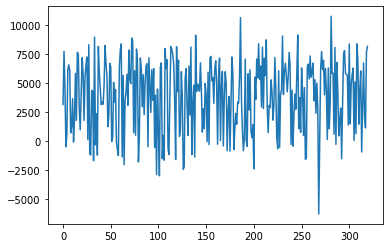

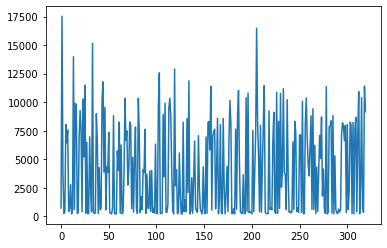

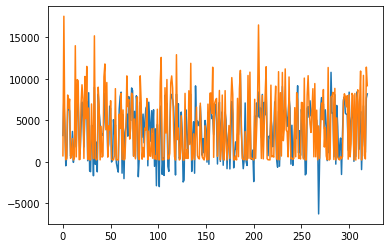

In [ ]:
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt

reg = linear_model.LinearRegression().fit(train_x,train_y)
x_pred = reg.predict(valid_x)
print(reg.score(valid_x,valid_y))
plt.plot(range(len(valid_y)),x_pred)
plt.figure()
plt.plot(range(len(valid_y)),valid_y)
plt.figure()
plt.plot(range(len(valid_y)),x_pred)
plt.plot(range(len(valid_y)),valid_y)



In [ ]:
x_pred

array([ 6.17257654e+02,  6.72645067e+03,  3.86331944e+03,  8.09431599e+03,
        7.35111321e+03,  2.61470112e+02,  6.56546775e+03,  4.26952153e+03,
        3.87301491e+03,  7.29752298e+03,  4.45001300e+03,  4.03637445e+03,
        3.78379757e+02,  7.41684864e+03,  4.96940178e+03,  7.33245636e+03,
        6.62404736e+03,  6.41119228e+03,  6.77815617e+03,  9.70852555e+01,
        6.58654527e+03,  6.85387566e+03,  4.18532220e+02,  1.88178588e+02,
        7.03088461e+03,  7.05060182e+03,  7.71703872e+03,  9.54713952e+01,
        8.43017508e+02,  5.82567538e+03,  2.87022618e+02,  7.98536149e+02,
        7.08082061e+03,  6.48142580e+03,  3.68681785e+02,  4.13969720e+02,
        6.99542720e+03,  7.80003165e+03,  4.03737139e+03,  4.44019466e+03,
        6.67023950e+03,  7.39409476e+03,  1.86255697e+02,  7.35937053e+03,
        7.58408426e+03,  4.92112399e+03,  7.13760177e+03,  6.80841386e+03,
        1.08824323e+02,  4.81298052e+03,  6.69744427e+03,  6.51344769e+03,
        6.66869516e+03,  

In [ ]:
valid_y

Date
2015-11-30      377.321014
2018-06-28     5903.439941
2017-02-23     1166.719971
2019-09-12    10410.126953
2019-10-27     9551.714844
                  ...     
2019-08-23    10407.964844
2019-12-18     7276.802734
2018-06-09     7531.979980
2018-10-07     6602.950195
2017-08-19     4193.700195
Name: Close, Length: 265, dtype: float64

0.5708676430460251


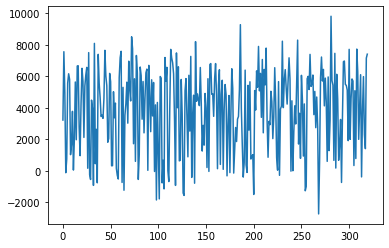

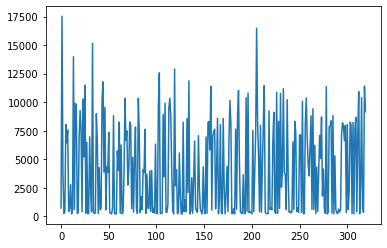

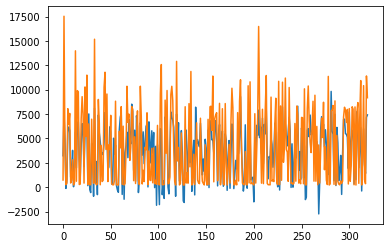

In [ ]:
rid = linear_model.Ridge(alpha=0.5)
rid.fit(train_x,train_y)
x_pred = rid.predict(valid_x)
print(rid.score(valid_x,valid_y))
plt.plot(range(len(valid_y)),x_pred)
plt.figure()
plt.plot(range(len(valid_y)),valid_y)
plt.figure()
plt.plot(range(len(valid_y)),x_pred)
plt.plot(range(len(valid_y)),valid_y)

0.5843879823019811


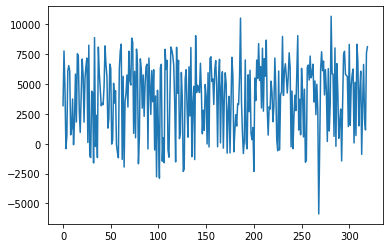

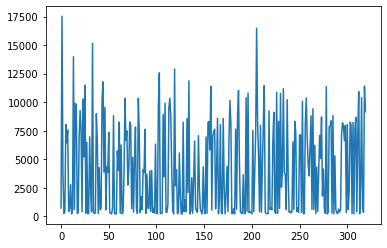

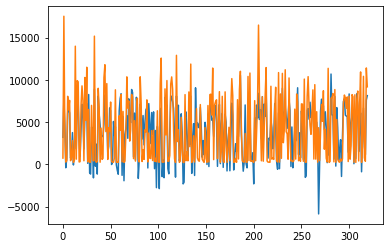

In [ ]:
lasso = linear_model.Lasso(alpha=0.8)
lasso.fit(train_x,train_y)
x_pred = lasso.predict(valid_x)
print(lasso.score(valid_x,valid_y))
plt.plot(range(len(valid_y)),x_pred)
plt.figure()
plt.plot(range(len(valid_y)),valid_y)
plt.figure()
plt.plot(range(len(valid_y)),x_pred)
plt.plot(range(len(valid_y)),valid_y)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_data = scaler.fit_transform(df, BTC_data['Close'])
scaler.fit_transform(df, BTC_data['Close'])
train_x, valid_x, train_y, valid_y = train_test_split(scale_data, BTC_data['Close'], test_size = 0.2)

svReg = SVR(C = 100000, epsilon = 0.5)
#C represents tradeoff in minimizing the correctness of the classifier and allowing support vectors
# epsilon is our error tolerance
svReg.fit(train_x,train_y)
x_pred = svReg.predict(valid_x)
print(svReg.score(valid_x,valid_y))

plt.plot(range(len(valid_y)),x_pred)
plt.figure()
plt.plot(range(len(valid_y)),valid_y)
plt.figure()
plt.plot(range(len(valid_y)),x_pred)
plt.plot(range(len(valid_y)),valid_y)

0.6435080728551275


NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import Callback

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scale_data = scaler.fit_transform(df, BTC_data['Close'])


In [ ]:
scale_data

array([[4.92560092e-02, 9.99379529e-02, 8.16326531e-02, 2.50589569e-01,
        7.85449784e-02, 6.45837249e-03],
       [8.23540593e-02, 4.22740704e-02, 1.22448980e-01, 1.74521000e-01,
        6.33703863e-02, 1.80807384e-02],
       [1.04952728e-01, 7.49332605e-02, 4.08163265e-02, 1.65291117e-01,
        9.11605356e-02, 1.43186235e-02],
       ...,
       [7.74866990e-02, 1.15452454e-04, 1.00040016e-01, 5.57525974e-02,
        2.90913669e-02, 3.80750488e-02],
       [1.11280573e-01, 1.93182818e-04, 2.42473227e-01, 3.23708497e-02,
        5.02254412e-03, 4.50346665e-02],
       [7.04282913e-02, 1.15452454e-04, 6.00240096e-02, 3.16903744e-02,
        2.00306052e-02, 4.24951970e-02]])

In [ ]:
scaler.fit_transform(df, BTC_data['Close'])

array([[4.92560092e-02, 9.99379529e-02, 8.16326531e-02, 2.50589569e-01,
        7.85449784e-02, 6.45837249e-03],
       [8.23540593e-02, 4.22740704e-02, 1.22448980e-01, 1.74521000e-01,
        6.33703863e-02, 1.80807384e-02],
       [1.04952728e-01, 7.49332605e-02, 4.08163265e-02, 1.65291117e-01,
        9.11605356e-02, 1.43186235e-02],
       ...,
       [7.74866990e-02, 1.15452454e-04, 1.00040016e-01, 5.57525974e-02,
        2.90913669e-02, 3.80750488e-02],
       [1.11280573e-01, 1.93182818e-04, 2.42473227e-01, 3.23708497e-02,
        5.02254412e-03, 4.50346665e-02],
       [7.04282913e-02, 1.15452454e-04, 6.00240096e-02, 3.16903744e-02,
        2.00306052e-02, 4.24951970e-02]])

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(scale_data, BTC_data['Close'], test_size = 0.2)

In [ ]:
train_y

Date
2014-12-08     361.908997
2018-11-12    6371.270020
2018-09-22    6721.979980
2019-04-14    5167.722168
2015-05-17     236.802002
                 ...     
2019-10-26    9244.972656
2017-05-23    2320.419922
2017-08-03    2804.729980
2018-03-25    8495.780273
2019-02-27    3851.047363
Name: Close, Length: 1056, dtype: float64

In [ ]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=20, restore_best_weights=True)

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 6.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=68deb8e7c02a519b57a9ebddd3759c439ab405302209505e21fa59b9f85644fa
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=d80548069235f58b40e9cb72b761edb0d478d764f7d822ce33fd13f6e2ac26bd
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow.keras as keras

In [ ]:
import kerastuner as kt

In [ ]:
def create_model(hp):
  train_x, valid_x, train_y, valid_y = train_test_split(scale_data, BTC_data['Close'], test_size = 0.3)
  model = Sequential()
  layers = hp.Int('num_layers', min_value=4, max_value=7)

  for layer in range(layers):
    model.add(Dense(hp.Int('layer: ' + str(layer), min_value=7, max_value=512), activation='relu'))
  
  model.add(Dense(1, activation='relu'))


  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.2, 0.3, 0.4])),loss="MSE")

  return model

In [ ]:
tuner = kt.Hyperband(create_model, objective='val_loss', max_epochs=500, hyperband_iterations=2)

In [ ]:
tuner.search(x=train_x, y=train_y.values, epochs=100, validation_data=(valid_x, valid_y))

Trial 1450 Complete [00h 01m 05s]
val_loss: 34952856.0

Best val_loss So Far: 4036693.5
Total elapsed time: 01h 30m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_params = tuner.get_best_hyperparameters(1)[0]

In [ ]:
best_params.get_config()

{'space': [{'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 10,
    'min_value': 4,
    'name': 'num_layers',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 0',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 1',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 2',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 3',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Choice',
   'config': {'conditions': [],
    'default': 0.

#Experiment for Shifting data

In [ ]:
df

,1,2,3,4,5,6
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616
...,...,...,...,...,...,...
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010
1594,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856


In [ ]:
scale_data

array([[4.92560092e-02, 9.99379529e-02, 8.16326531e-02, 2.50589569e-01,
        7.85449784e-02, 6.45837249e-03],
       [8.23540593e-02, 4.22740704e-02, 1.22448980e-01, 1.74521000e-01,
        6.33703863e-02, 1.80807384e-02],
       [1.04952728e-01, 7.49332605e-02, 4.08163265e-02, 1.65291117e-01,
        9.11605356e-02, 1.43186235e-02],
       ...,
       [7.74866990e-02, 1.15452454e-04, 1.00040016e-01, 5.57525974e-02,
        2.90913669e-02, 3.80750488e-02],
       [1.11280573e-01, 1.93182818e-04, 2.42473227e-01, 3.23708497e-02,
        5.02254412e-03, 4.50346665e-02],
       [7.04282913e-02, 1.15452454e-04, 6.00240096e-02, 3.16903744e-02,
        2.00306052e-02, 4.24951970e-02]])

In [ ]:
df

,1,2,3,4,5,6
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616
...,...,...,...,...,...,...
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010
1594,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856


In [ ]:
data_copy = df[:]
data_copy['BTC_OPEN'] = BTC_data['Open'].values
data_copy['BTC_HIGH'] = BTC_data['High'].values
data_copy['BTC_LOW'] = BTC_data['Low'].values
data_copy['BTC_VOLUME'] = BTC_data['Volume'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
df

,1,2,3,4,5,6
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616
...,...,...,...,...,...,...
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010
1594,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856


In [ ]:
data_copy

,1,2,3,4,5,6,BTC_OPEN,BTC_HIGH,BTC_LOW,BTC_VOLUME
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994,424.102997,427.834991,384.532013,37919700
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536,394.673004,423.295990,389.882996,36863600
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997,408.084991,412.425995,393.181000,26580100
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922,399.100006,406.915985,397.130005,24127600
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616,402.092010,441.557007,396.196991,45099500
...,...,...,...,...,...,...,...,...,...,...
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107,7317.647461,7513.948242,7279.865234,22445257702
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344,7420.272949,7454.824219,7276.308105,22874131672
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010,7294.438965,7335.290039,7169.777832,21167946112
1594,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856,7194.892090,7254.330566,7174.944336,18565664997


In [ ]:
lookAhead = 1

In [ ]:
BTC_data['Close']

Date
2014-09-19     394.795990
2014-09-20     408.903992
2014-09-21     398.821014
2014-09-22     402.152008
2014-09-23     435.790985
                 ...     
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
2020-01-01    7200.174316
2020-01-02    6985.470215
Name: Close, Length: 1596, dtype: float64

In [ ]:
LookAhead_y = BTC_data['Close'][lookAhead:]

In [ ]:
LookAhead_y

Date
2014-09-20     408.903992
2014-09-21     398.821014
2014-09-22     402.152008
2014-09-23     435.790985
2014-09-24     423.204987
                 ...     
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
2020-01-01    7200.174316
2020-01-02    6985.470215
Name: Close, Length: 1595, dtype: float64

In [ ]:
LookAhead_x = data_copy[:-1]

In [ ]:
LookAhead_x

,1,2,3,4,5,6,BTC_OPEN,BTC_HIGH,BTC_LOW,BTC_VOLUME
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994,424.102997,427.834991,384.532013,37919700
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536,394.673004,423.295990,389.882996,36863600
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997,408.084991,412.425995,393.181000,26580100
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922,399.100006,406.915985,397.130005,24127600
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616,402.092010,441.557007,396.196991,45099500
...,...,...,...,...,...,...,...,...,...,...
1590,25.366337,1.019802,0.049505,0.150011,0.180948,0.669041,7289.031250,7399.041016,7286.905273,21365673026
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107,7317.647461,7513.948242,7279.865234,22445257702
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344,7420.272949,7454.824219,7276.308105,22874131672
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010,7294.438965,7335.290039,7169.777832,21167946112


In [ ]:
scaler = MinMaxScaler()
scale_data = scaler.fit_transform(LookAhead_x, LookAhead_y)

In [ ]:
scale_data

array([[4.92560092e-02, 9.99379529e-02, 8.16326531e-02, ...,
        1.23483270e-02, 1.28379960e-02, 7.09650970e-04],
       [8.23540593e-02, 4.22740704e-02, 1.22448980e-01, ...,
        1.20889654e-02, 1.31604786e-02, 6.86234024e-04],
       [1.04952728e-01, 7.49332605e-02, 4.08163265e-02, ...,
        1.14678466e-02, 1.33592363e-02, 4.58217586e-04],
       ...,
       [7.12829294e-02, 2.13644194e-03, 1.61648818e-01, ...,
        4.13875210e-01, 4.28178132e-01, 5.07057851e-01],
       [7.74866990e-02, 1.15452454e-04, 1.00040016e-01, ...,
        4.07044947e-01, 4.21757973e-01, 4.69226533e-01],
       [1.11280573e-01, 1.93182818e-04, 2.42473227e-01, ...,
        4.02418868e-01, 4.22069338e-01, 4.11526055e-01]])

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(scale_data, LookAhead_y, test_size = 0.3)

In [ ]:
train_x

array([[3.85066424e-02, 8.25092505e-02, 8.16326531e-02, ...,
        1.48371487e-03, 3.84407034e-03, 1.14748355e-04],
       [5.76555144e-02, 8.68271722e-02, 6.12244898e-02, ...,
        1.16113836e-02, 1.37707331e-02, 3.44707151e-04],
       [8.36039857e-02, 4.51396003e-02, 4.08163265e-02, ...,
        6.98390470e-03, 8.65673704e-03, 7.01850495e-04],
       ...,
       [5.98553848e-02, 6.06448648e-02, 6.12244898e-02, ...,
        2.88360465e-03, 5.07078557e-03, 2.48682375e-04],
       [7.11635421e-02, 2.17820296e-02, 1.40056022e-01, ...,
        5.89269952e-01, 5.83614550e-01, 4.48389664e-01],
       [6.82715556e-02, 1.14721255e-01, 1.60064026e-01, ...,
        3.80114559e-01, 3.86168603e-01, 8.76980355e-02]])

In [ ]:
def create_lookahead_model(hp):
  model = Sequential()
  layers = hp.Int('num_layers', min_value=4, max_value=10)

  for layer in range(layers):
    model.add(Dense(hp.Int('layer: ' + str(layer), min_value=7, max_value=2048), activation='relu'))
  
  model.add(Dense(1, activation='relu'))


  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.2, 0.3, 0.4])),loss="MSE")

  return model

In [ ]:
tuner = kt.Hyperband(create_lookahead_model, objective='val_loss', max_epochs=150, hyperband_iterations=2,project_name="LookaheadNew2")

In [ ]:
tuner.search(x=train_x, y=train_y.values, epochs=100, validation_data=(valid_x, valid_y))

Trial 508 Complete [00h 00m 29s]
val_loss: 27476334.0

Best val_loss So Far: 78389.6484375
Total elapsed time: 00h 29m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_model.save('CurrBestKerasModel')

ValueError: ignored

In [ ]:
!zip kerasmodel.zip CurrBestKerasModel

  adding: CurrBestKerasModel/ (stored 0%)


In [ ]:
best_params = tuner.get_best_hyperparameters(1)[0]

In [ ]:
best_params.get_config()

{'space': [{'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 10,
    'min_value': 4,
    'name': 'num_layers',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 0',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 1',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 2',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 2048,
    'min_value': 7,
    'name': 'layer: 3',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Choice',
   'config': {'conditions': [],
    'default': 0.

In [ ]:
NN_pred_X = best_model.predict(valid_x)

In [ ]:
valid_x

array([[0.0311659 , 0.11795392, 0.020008  , ..., 0.51029758, 0.45952745,
        0.28206289],
       [0.07060475, 0.05652321, 0.08163265, ..., 0.00056341, 0.00170318,
        0.00072077],
       [0.08009429, 0.09894961, 0.0404122 , ..., 0.49411807, 0.50906044,
        0.40721048],
       ...,
       [0.33218934, 0.04792662, 0.18367347, ..., 0.19816322, 0.19288814,
        0.04468478],
       [0.05925394, 0.06797406, 0.08082441, ..., 0.38129451, 0.39282618,
        0.0889823 ],
       [0.06628322, 0.12261851, 0.0404122 , ..., 0.21703618, 0.22711853,
        0.17226707]])

In [ ]:
NN_pred_X

array([[ 8599.91   ],
       [  281.3785 ],
       [ 8717.39   ],
       [ 5464.449  ],
       [  268.2421 ],
       [ 3753.3123 ],
       [ 9364.841  ],
       [  269.16037],
       [  270.11505],
       [  330.6346 ],
       [  656.4096 ],
       [ 1125.005  ],
       [ 7143.702  ],
       [ 8737.574  ],
       [  282.39896],
       [  299.7251 ],
       [  276.6035 ],
       [ 4098.5645 ],
       [ 6913.135  ],
       [ 9531.305  ],
       [  643.65546],
       [  406.28717],
       [14896.031  ],
       [  280.3942 ],
       [  356.43033],
       [12109.9    ],
       [  418.76205],
       [ 6438.608  ],
       [  564.66614],
       [  268.35974],
       [ 8349.157  ],
       [ 8497.451  ],
       [ 7336.686  ],
       [  395.34857],
       [  418.36047],
       [ 8043.2715 ],
       [  424.2569 ],
       [12326.37   ],
       [  269.2007 ],
       [11597.53   ],
       [  267.21704],
       [ 7350.8726 ],
       [  668.404  ],
       [  411.12762],
       [  287.1975 ],
       [ 7

In [ ]:
sklearn.metrics.r2_score(NN_pred_X, valid_y)

0.9942782229043742

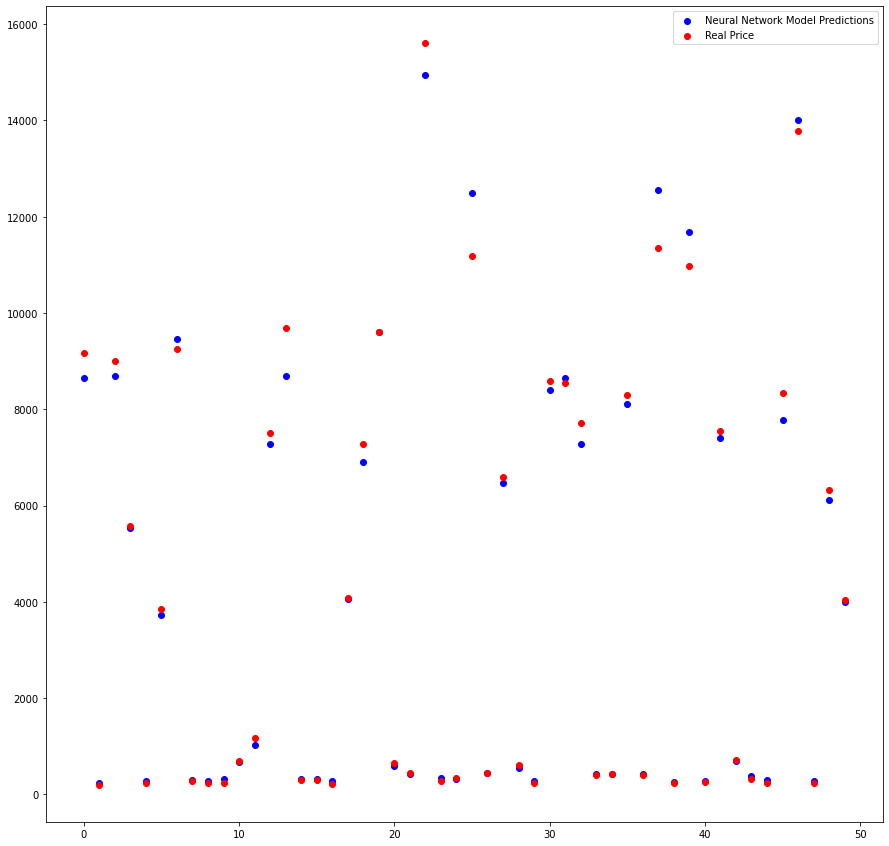

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(valid_y[:50])), NN_pred_X[:50], c='b', label="Neural Network Model Predictions")
ax1.scatter(range(len(valid_y[:50])), valid_y[:50], c='r', label="Real Price")
plt.legend(loc='upper right')

In [ ]:
BTC_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
...,...,...,...,...,...,...
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702
2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672
2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112


In [ ]:
df

,1,2,3,4,5,6
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616
...,...,...,...,...,...,...
1316,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107
1317,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344
1318,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010
1319,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856


In [ ]:
data_copy = df[:]

In [ ]:
data_copy['BTC_OPEN'] = BTC_data['Open'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_copy['BTC_HIGH'] = BTC_data['High'].values
data_copy['BTC_LOW'] = BTC_data['Low'].values
data_copy['BTC_VOLUME'] = BTC_data['Volume'].values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
data_copy

,1,2,3,4,5,6,BTC_OPEN,BTC_HIGH,BTC_LOW,BTC_VOLUME
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994,424.102997,427.834991,384.532013,37919700
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536,394.673004,423.295990,389.882996,36863600
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997,408.084991,412.425995,393.181000,26580100
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922,399.100006,406.915985,397.130005,24127600
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616,402.092010,441.557007,396.196991,45099500
...,...,...,...,...,...,...,...,...,...,...
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107,7317.647461,7513.948242,7279.865234,22445257702
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344,7420.272949,7454.824219,7276.308105,22874131672
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010,7294.438965,7335.290039,7169.777832,21167946112
1594,26.435644,1.019802,0.118812,0.144615,0.129530,0.725856,7194.892090,7254.330566,7174.944336,18565664997


In [ ]:
LookAhead_y

Date
2014-09-20     408.903992
2014-09-21     398.821014
2014-09-22     402.152008
2014-09-23     435.790985
2014-09-24     423.204987
                 ...     
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
2020-01-01    7200.174316
2020-01-02    6985.470215
Name: Close, Length: 1595, dtype: float64

In [ ]:
lookAhead = 1
LookAhead_y = BTC_data['Close'][lookAhead:]
LookAhead_y
LookAhead_x = data_copy[:-1]
LookAhead_x


,1,2,3,4,5,6,BTC_OPEN,BTC_HIGH,BTC_LOW,BTC_VOLUME
0,14.030000,26.430000,0.040000,0.291998,0.203007,0.504994,424.102997,427.834991,384.532013,37919700
1,20.650000,11.740000,0.060000,0.240622,0.187842,0.571536,394.673004,423.295990,389.882996,36863600
2,25.170000,20.060000,0.020000,0.234388,0.215615,0.549997,408.084991,412.425995,393.181000,26580100
3,18.960000,21.740000,0.040000,0.249943,0.189135,0.560922,399.100006,406.915985,397.130005,24127600
4,17.540000,14.310000,0.030000,0.267956,0.183428,0.548616,402.092010,441.557007,396.196991,45099500
...,...,...,...,...,...,...,...,...,...,...
1590,25.366337,1.019802,0.049505,0.150011,0.180948,0.669041,7289.031250,7399.041016,7286.905273,21365673026
1591,21.607843,1.039216,0.088235,0.134618,0.154275,0.711107,7317.647461,7513.948242,7279.865234,22445257702
1592,18.435644,1.514851,0.079208,0.160088,0.150567,0.689344,7420.272949,7454.824219,7276.308105,22874131672
1593,19.676471,1.000000,0.049020,0.160406,0.153584,0.686010,7294.438965,7335.290039,7169.777832,21167946112


In [ ]:
LookAhead_y

Date
2014-09-20     408.903992
2014-09-21     398.821014
2014-09-22     402.152008
2014-09-23     435.790985
2014-09-24     423.204987
                 ...     
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
2020-01-01    7200.174316
2020-01-02    6985.470215
Name: Close, Length: 1595, dtype: float64

In [ ]:
train_x[0].shape

(6,)

In [ ]:
def create_lookahead_model(hp):
  model = Sequential()
  layers = hp.Int('num_layers', min_value=4, max_value=15)

  for layer in range(layers):
    model.add(Dense(hp.Int('layer: ' + str(layer), min_value=7, max_value=2048), activation='relu'))
  
  model.add(Dense(1, activation='relu'))


  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.2, 0.3, 0.4])),loss="MSE")

  return model

In [ ]:
tuner = kt.Hyperband(create_lookahead_model, objective='val_loss', max_epochs=500, hyperband_iterations=2,project_name="biggggggerermodel")

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-bea27fdf9be9>", line 2, in create_lookahead_model
    model = Sequential()
NameError: name 'Sequential' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-bea27fdf9be9>", line 2, in create_lookahead_model
    model = Sequential()
NameError: name 'Sequential' is not defined


Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-bea27fdf9be9>", line 2, in create_lookahead_model
    model = Sequential()
NameError: name 'Sequential' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-bea27fdf9be9>", line 2, in create_lookahead_model
    model = Sequential()
NameError: name 'Sequential' is not defined
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-bea27fdf9be9>", line 2, in create_lookahead_model
    model = Sequential()
NameError: name 'Sequential' is not defined


Invalid model 2/5
Invalid model 3/5
Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-bea27fdf9be9>", line 2, in create_lookahead_model
    model = Sequential()
NameError: name 'Sequential' is not defined


RuntimeError: ignored

In [ ]:
tuner.search(x=train_x, y=train_y.values, epochs=100, validation_data=(valid_x, valid_y))

Trial 145 Complete [00h 00m 10s]
val_loss: 35673772.0

Best val_loss So Far: 35673772.0
Total elapsed time: 00h 19m 24s

Search: Running Trial #146

Hyperparameter    |Value             |Best Value So Far 
num_layers        |9                 |14                
layer: 0          |209               |1036              
layer: 1          |845               |417               
layer: 2          |530               |102               
layer: 3          |599               |751               
learning_rate     |0.2               |0.2               
layer: 4          |627               |1171              
layer: 5          |1029              |686               
layer: 6          |98                |562               
layer: 7          |1326              |1687              
layer: 8          |1225              |1375              
layer: 9          |1026              |1150              
layer: 10         |1247              |1648              
layer: 11         |1098              |1199           

#Evaluating Hyperparameter Tuning of Keras model

In [ ]:
tuner.get_best_hyperparameters.config()

AttributeError: ignored

In [ ]:
best_model = tuner.get_best_models(3)[0]

In [ ]:
best_model.save('CurrentNNModel')

ValueError: ignored

In [ ]:
NN_pred_X = best_model.predict(valid_x)

In [ ]:
!zip currentNNModel.zip CurrentNNModel 

  adding: CurrentNNModel/ (stored 0%)


In [ ]:
import matplotlib.pyplot as plt

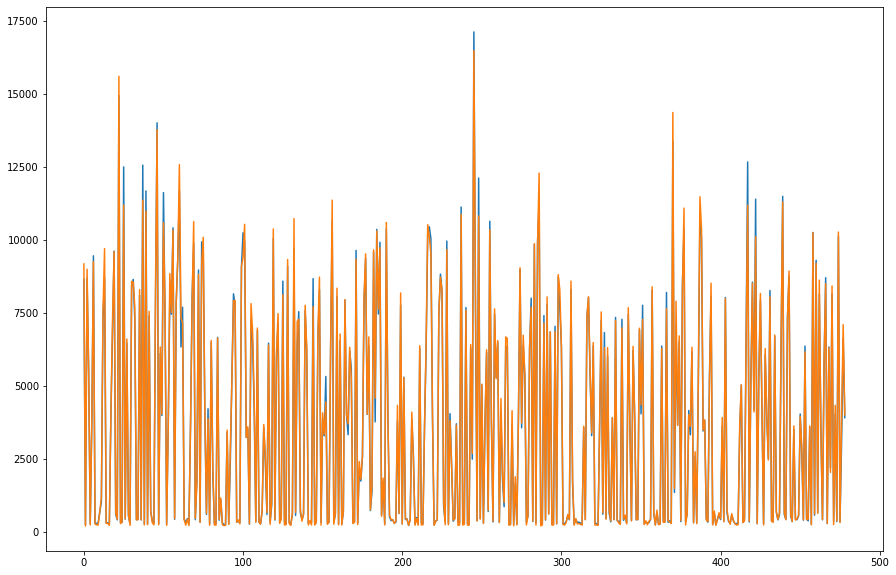

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(len(valid_y)),NN_pred_X)
plt.plot(range(len(valid_y)),valid_y)

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.r2_score(valid_y, NN_pred_X)

0.9943148129075707

In [ ]:
best_params.get_config()

{'space': [{'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 7,
    'min_value': 4,
    'name': 'num_layers',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 512,
    'min_value': 7,
    'name': 'layer: 0',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 512,
    'min_value': 7,
    'name': 'layer: 1',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 512,
    'min_value': 7,
    'name': 'layer: 2',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 512,
    'min_value': 7,
    'name': 'layer: 3',
    'sampling': None,
    'step': 1}},
  {'class_name': 'Choice',
   'config': {'conditions': [],
    'default': 0.1,
  

In [ ]:
df = pd.read_csv('./stackedData.csv')
df = df.drop(['Unnamed: 0', '0'], axis=1)

,1,2,3,4,5,6
0,19.880000,26.44,0.020000,0.261727,0.166478,0.571795
1,26.170000,31.60,0.090000,0.249869,0.181214,0.568917
2,23.020000,22.14,0.090000,0.243996,0.208106,0.547898
3,14.930000,7.93,0.040000,0.289944,0.197901,0.512155
4,17.140000,20.63,0.050000,0.289193,0.175671,0.535136
...,...,...,...,...,...,...
727,19.715686,1.00,0.019608,0.169069,0.152520,0.678411
728,20.425743,1.00,0.049505,0.176367,0.142137,0.681495
729,21.138614,1.00,0.029703,0.172337,0.148946,0.678717
730,19.862745,1.00,0.058824,0.171575,0.145885,0.682539


In [ ]:
scaler = MinMaxScaler()
scale_data = scaler.fit_transform(df, BTC_data['Close'])

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(scale_data, BTC_data['Close'], test_size = 0.3)

In [ ]:
best_NN_Model = Sequential()
best_NN_Model.add(Dense(96, activation='relu'))
best_NN_Model.add(Dense(473, activation='relu'))
best_NN_Model.add(Dense(110, activation='relu'))
best_NN_Model.add(Dense(133, activation='relu'))
best_NN_Model.add(Dense(209, activation='relu'))
best_NN_Model.add(Dense(436, activation='relu'))
best_NN_Model.add(Dense(1, activation='relu'))

adam = tf.keras.optimizers.Adam(learning_rate=0.1)

best_NN_Model.compile(loss="MSE", optimizer=adam)

In [ ]:
best_NN_Model.fit(x=train_x, y=train_y.values, epochs=150, validation_data=(valid_x, valid_y), callbacks=[earlyStop])

Epoch 1/150
16/16 [==============================] - 1s 17ms/step - loss: 584186707.7647 - val_loss: 25507836.0000
Epoch 2/150
16/16 [==============================] - 0s 5ms/step - loss: 24376573.1765 - val_loss: 25507836.0000
Epoch 3/150
16/16 [==============================] - 0s 5ms/step - loss: 24344816.7059 - val_loss: 25507836.0000
Epoch 4/150
16/16 [==============================] - 0s 5ms/step - loss: 24962728.5882 - val_loss: 25507836.0000
Epoch 5/150
16/16 [==============================] - 0s 5ms/step - loss: 25040330.1176 - val_loss: 25507836.0000
Epoch 6/150
16/16 [==============================] - 0s 5ms/step - loss: 22300442.0588 - val_loss: 25507836.0000
Epoch 7/150
16/16 [==============================] - 0s 5ms/step - loss: 25101738.0000 - val_loss: 25507836.0000
Epoch 8/150
16/16 [==============================] - 0s 5ms/step - loss: 23283641.8824 - val_loss: 25507836.0000
Epoch 9/150
16/16 [==============================] - 0s 5ms/step - loss: 27101957.6471 - val_l

In [ ]:
pred = best_NN_Model.predict(valid_x)

In [ ]:
import matplotlib.pyplot as plt

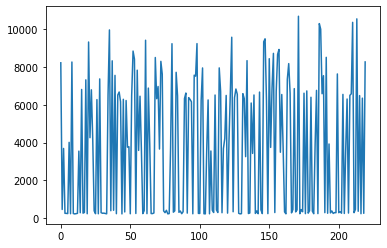

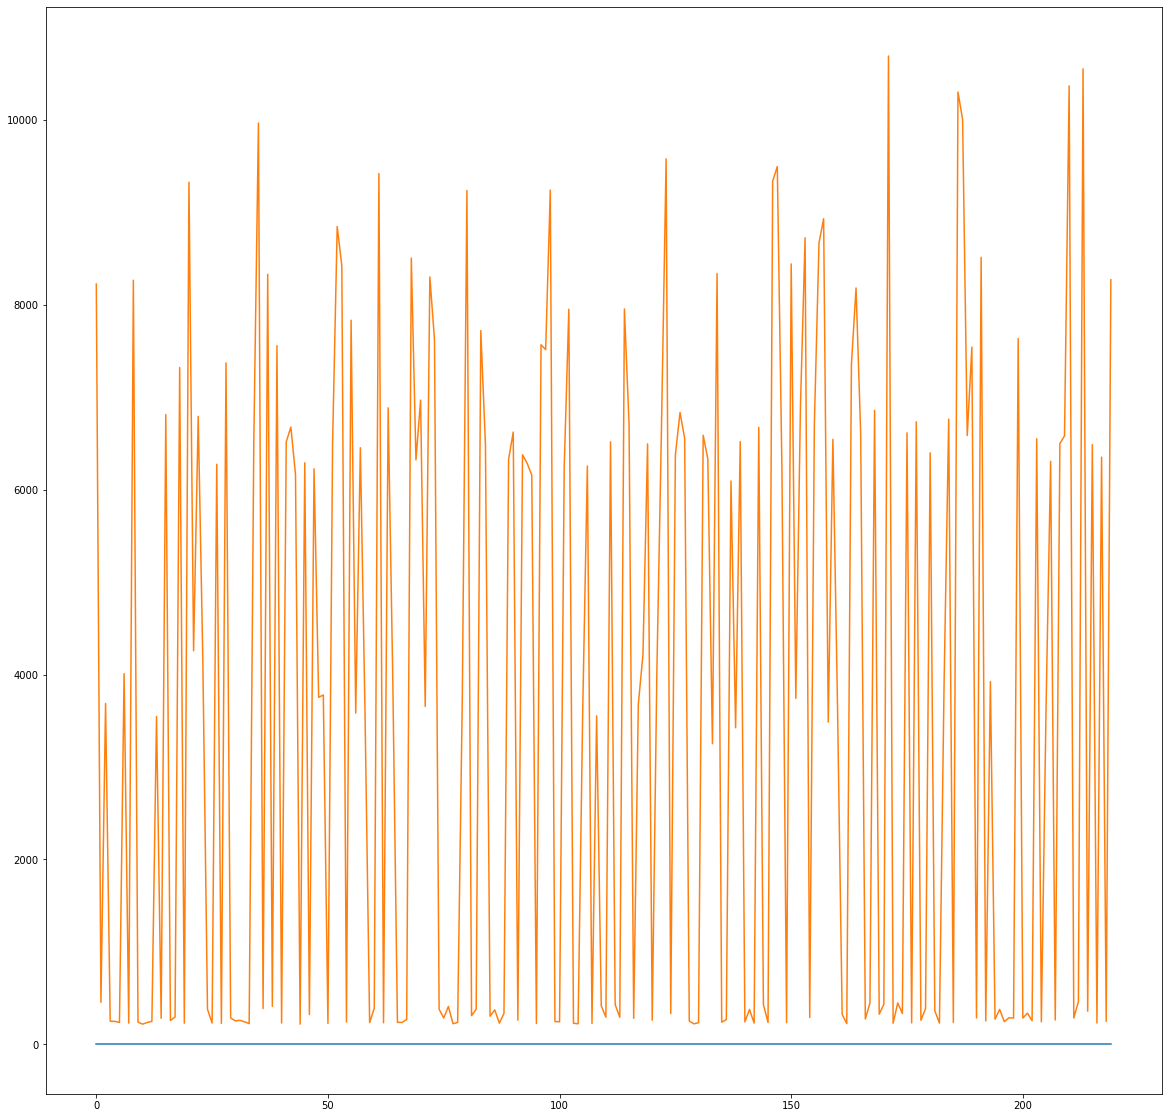

In [ ]:
plt.figure()
plt.plot(range(len(valid_y)),valid_y)
plt.figure(figsize=(20,20))
plt.plot(range(len(valid_y)),pred)
plt.plot(range(len(valid_y)),valid_y)

In [ ]:
sklearn.metrics.r2_score(valid_y, pred)

0.9697904436239874

In [ ]:
NN_model = Sequential()

NN_model.add(Dense(7, activation='relu'))
NN_model.add(Dense(5, activation='relu'))
NN_model.add(Dense(2, activation='relu'))

NN_model.add(Dense(1))


adam = tf.keras.optimizers.Adam(learning_rate=0.2)

NN_model.compile(loss='MSE', optimizer=adam)

In [ ]:
NN_model.fit(x=train_x, y=train_y.values, epochs=500, validation_data=(valid_x, valid_y), callbacks=[earlyStop])

Epoch 1/500
19/19 [==============================] - 3s 18ms/step - loss: 26201342.6000 - val_loss: 27158706.0000
Epoch 2/500
19/19 [==============================] - 0s 3ms/step - loss: 23857315.1000 - val_loss: 27130780.0000
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 23104878.2000 - val_loss: 27102900.0000
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 25562882.7000 - val_loss: 27075378.0000
Epoch 5/500
19/19 [==============================] - 0s 3ms/step - loss: 24815466.7000 - val_loss: 27047708.0000
Epoch 6/500
19/19 [==============================] - 0s 3ms/step - loss: 24891987.0000 - val_loss: 27019640.0000
Epoch 7/500
19/19 [==============================] - 0s 3ms/step - loss: 25215228.3000 - val_loss: 26991570.0000
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 24746058.9000 - val_loss: 26963962.0000
Epoch 9/500
19/19 [==============================] - 0s 4ms/step - loss: 23945531.4000 - val_lo

In [ ]:
NN_pred_X = NN_model.predict(valid_x)

In [ ]:
x_pred = NN_pred_X

In [ ]:
valid_y

Date
2015-08-07      260.997009
2018-12-27     3654.833496
2018-03-26     7833.040039
2018-06-09     6786.020020
2015-08-06      279.584991
                  ...     
2018-02-22    10005.000000
2018-03-10     8866.000000
2018-05-26     7368.220215
2015-12-24      454.984985
2018-07-06     6856.930176
Name: Close, Length: 147, dtype: float64

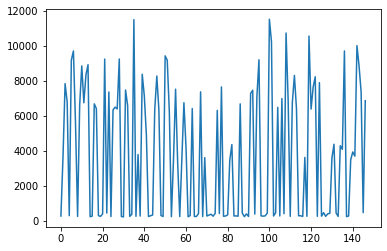

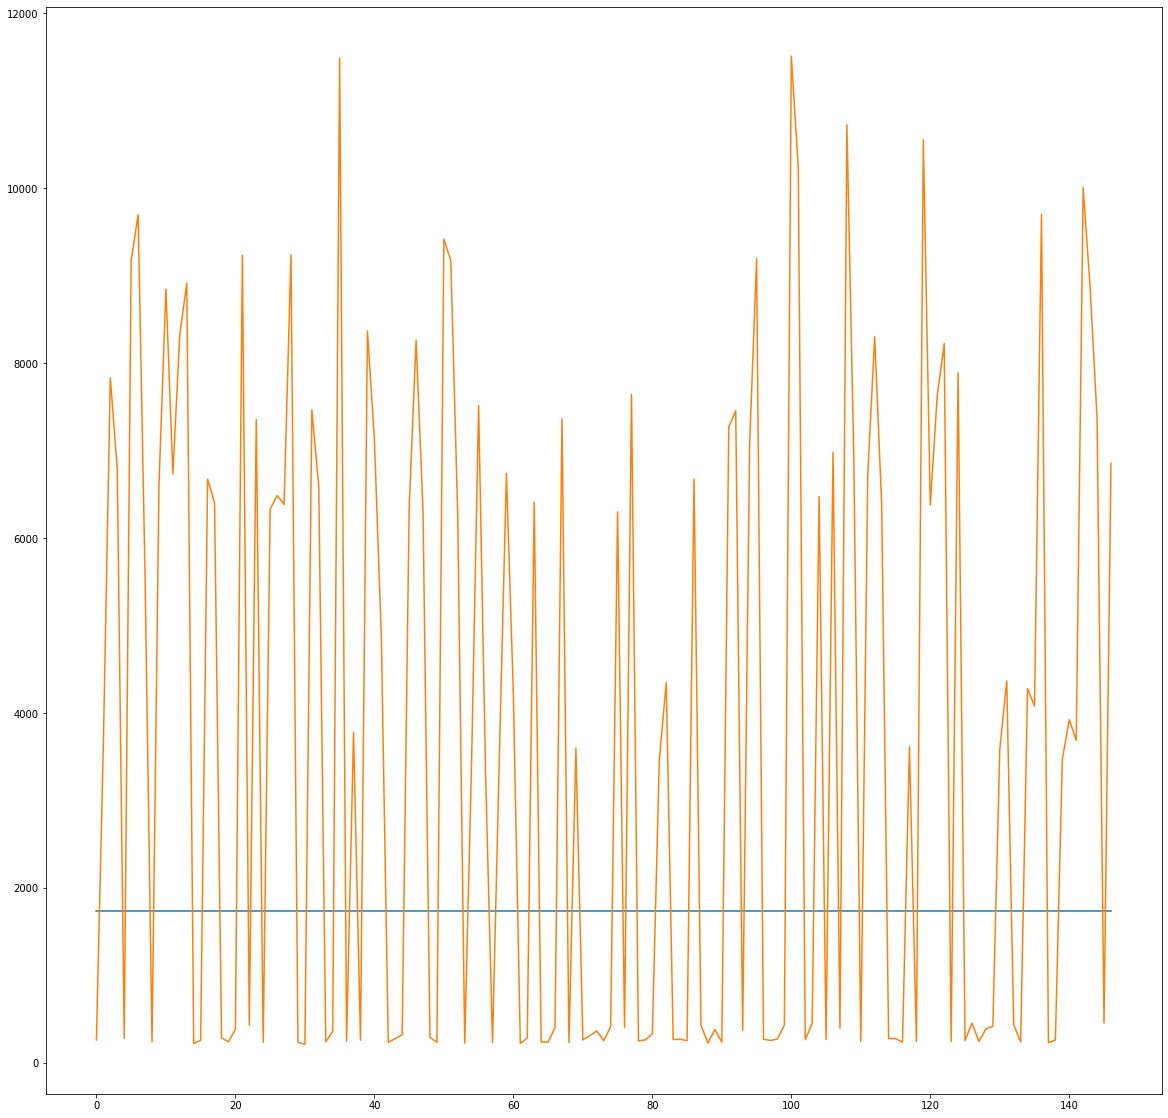

In [ ]:
plt.figure()
plt.plot(range(len(valid_y)),valid_y)
plt.figure(figsize=(20,20))
plt.plot(range(len(valid_y)),x_pred)
plt.plot(range(len(valid_y)),valid_y)

In [ ]:
sklearn.metrics.r2_score(valid_y, x_pred)

-0.30701551838410657

0.21428702723743798


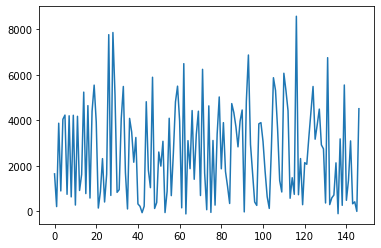

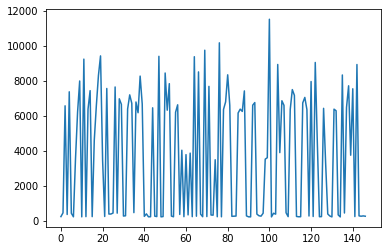

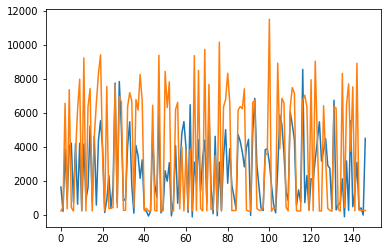

#Begin Backtesting

In [ ]:
!pip install backtrader

     |████████████████████████████████| 419kB 5.1MB/s 


In [ ]:
import backtrader as bt

In [ ]:
from datetime import datetime

Starting Portfolio Value: 10000.00
Final Portfolio Value: 22590.61


<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

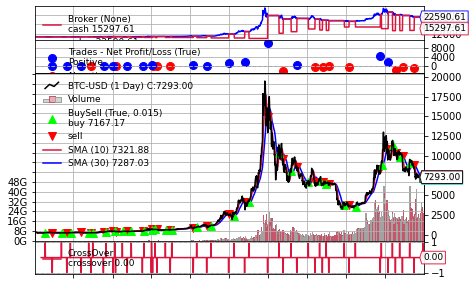

In [ ]:

class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

data0 = bt.feeds.YahooFinanceData(dataname='BTC-USD', fromdate=datetime(2015, 1, 1),
                                  todate=datetime(2019, 12, 31))
cerebro.adddata(data0)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()


# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

In [ ]:
(15354.109999999993+ 16031.360000000008+ 19416.620000000003+ 11283.119999999997+ 12195.379999999996+ 11064.820000000002+ 20654.41+ 14976.280000000006+ 11079.740000000002+ 19090.07+ 18965.699999999997+ 16620.140000000003+ 12797.62+ 10437.269999999999+ 19204.559999999998+ 14945.910000000003+ 15922.73+ 11479.319999999998+ 11460.570000000002+ 14275.969999999994+ 10832.899999999996+ 12785.84+ 14363.539999999997+ 12354.369999999995+ 15403.370000000003+ 12362.28+ 13429.709999999997+ 14859.32+ 16626.350000000006+ 16072.290000000005+ 16159.840000000004+ 20956.200000000004+ 16878.86+ 17485.629999999997+ 15044.260000000002+ 22171.899999999998+ 14753.139999999996+ 13707.130000000005+ 14883.559999999998+ 9654.03+ 15172.049999999994+ 22261.2+ 14682.300000000001+ 19383.28+ 15977.939999999995+ 17146.740000000005+ 15479.02+ 11290.759999999997+ 19113.71+ 11374.669999999996+ 14343.170000000004+ 19914.94+ 19437.28+ 14041.930000000008+ 12149.97+ 14519.180000000004+ 14326.2+ 16097.680000000002+ 18675.02+ 13327.26+ 12636.269999999997+ 11664.980000000001+ 17620.159999999996+ 11270.510000000002+ 14226.250000000005+ 15460.560000000005+ 14660.79+ 14428.279999999999+ 15527.0+ 15148.18+ 16406.810000000005+ 14473.989999999998+ 14222.409999999996+ 16512.479999999996+ 14455.740000000003+ 15023.499999999996+ 13033.39+ 16692.97+ 15886.889999999994+ 15549.48+ 14674.61+ 9878.67+ 18018.38+ 7670.880000000003+ 10072.339999999998+ 16860.979999999996+ 15618.600000000002+ 15932.47+ 14536.469999999994+ 14794.099999999999+ 14563.759999999997+ 13315.900000000003+ 15188.529999999999+ 15463.629999999996+ 12248.64+ 12492.779999999997+ 12894.970000000001+ 10616.659999999998+ 16363.98+ 14865.890000000005)/100

14877.273999999994

In [ ]:
14877.274 - 10,000

(14867.274, 0)

In [ ]:
sub

(14867.273999999994, 0)